# 1. Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import plotly.express as px

import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from scipy.spatial.distance import cdist


# 2. Load Dataset

In [2]:
# Menghubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path file CSV di Google Drive
file_path = '/content/drive/My Drive/JAP Rakamin/Predict Customer Personality to Boost Marketing Campaign by Using Machine Learning/marketing_campaign_data.csv'

# Membaca file CSV menggunakan pandas
df = pd.read_csv(file_path)

Mounted at /content/drive


# 3. Dataset Overview

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2240 non-null   int64  
 1   ID                   2240 non-null   int64  
 2   Year_Birth           2240 non-null   int64  
 3   Education            2240 non-null   object 
 4   Marital_Status       2240 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2240 non-null   int64  
 7   Teenhome             2240 non-null   int64  
 8   Dt_Customer          2240 non-null   object 
 9   Recency              2240 non-null   int64  
 10  MntCoke              2240 non-null   int64  
 11  MntFruits            2240 non-null   int64  
 12  MntMeatProducts      2240 non-null   int64  
 13  MntFishProducts      2240 non-null   int64  
 14  MntSweetProducts     2240 non-null   int64  
 15  MntGoldProds         2240 non-null   i

Key Takeaways:

- Dataset terdapat 2.240 baris dan 30 kolom
- Dataset terdiri dari 26 kolom bertipe **int64**, 1 kolom bertipe **float64**, dan 3 kolom bertipe **object**
- Terdapa null value pada kolom **Income**

# 4. Feature Engineering

In [4]:
df.columns

Index(['Unnamed: 0', 'ID', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntCoke',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [5]:
import numpy as np
import pandas as pd

# Assuming the dataframe is already loaded as df
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)

df['Age'] = 2022 - df['Year_Birth']
df['join_at_age'] = df['Dt_Customer'].dt.year - df['Year_Birth']
df['total_kids'] = df['Kidhome'] + df['Teenhome']
df['is_parents'] = np.where(df['total_kids'] > 0, 1, 0)

# age_range
df.loc[(df['Age'] >= 0) & (df['Age'] < 12), 'age_range'] = "child"
df.loc[(df['Age'] >= 12) & (df['Age'] < 18), 'age_range'] = "teens"
df.loc[(df['Age'] >= 18) & (df['Age'] < 36), 'age_range'] = "young_adults"
df.loc[(df['Age'] >= 36) & (df['Age'] < 55), 'age_range'] = "middle_aged_adults"
df.loc[(df['Age'] >= 55), 'age_range'] = "older_adults"

# amount spent
df['Total_Spending'] = df['MntCoke'] \
                          + df['MntFruits'] \
                          + df['MntMeatProducts'] \
                          + df['MntFishProducts'] \
                          + df['MntSweetProducts'] \
                          + df['MntGoldProds']

# accepted campaigns
df['Total_Accepted_Campaign'] = df['AcceptedCmp1'] \
                               + df['AcceptedCmp2'] \
                               + df['AcceptedCmp3'] \
                               + df['AcceptedCmp4'] \
                               + df['AcceptedCmp5']

# total transaction purchased --- WE ASSUMED ALL OF THIS PURCHASES ARE MECE (mutually exclusive and collectively exhaustive)
df['Total_Transaction'] = df['NumDealsPurchases'] \
                         + df['NumWebPurchases'] \
                         + df['NumCatalogPurchases'] \
                         + df['NumStorePurchases']

def safe_div(x, y):
    if y == 0:
        return 0
    return x / y

df['Conversion_Rate'] = df.apply(lambda x: safe_div(x['Total_Transaction'], x['NumWebVisitsMonth']), axis=1)


In [6]:
df.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,Response,Age,join_at_age,total_kids,is_parents,age_range,Total_Spending,Total_Accepted_Campaign,Total_Transaction,Conversion_Rate
0,0,5524,1957,S1,Lajang,58138000.0,0,0,2012-09-04,58,...,1,65,55,0,0,older_adults,1617000,0,25,3.571429
1,1,2174,1954,S1,Lajang,46344000.0,1,1,2014-03-08,38,...,0,68,60,2,1,older_adults,27000,0,6,1.200000
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,2013-08-21,26,...,0,57,48,0,0,older_adults,776000,0,21,5.250000
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,2014-02-10,26,...,0,38,30,1,1,middle_aged_adults,53000,0,8,1.333333
4,4,5324,1981,S3,Menikah,58293000.0,1,0,2014-01-19,94,...,0,41,33,1,1,middle_aged_adults,422000,0,19,3.800000


# 5 Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               2240 non-null   int64         
 1   ID                       2240 non-null   int64         
 2   Year_Birth               2240 non-null   int64         
 3   Education                2240 non-null   object        
 4   Marital_Status           2240 non-null   object        
 5   Income                   2216 non-null   float64       
 6   Kidhome                  2240 non-null   int64         
 7   Teenhome                 2240 non-null   int64         
 8   Dt_Customer              2240 non-null   datetime64[ns]
 9   Recency                  2240 non-null   int64         
 10  MntCoke                  2240 non-null   int64         
 11  MntFruits                2240 non-null   int64         
 12  MntMeatProducts          2240 non-

In [8]:
# Pengelompokkan Feature
num = df.select_dtypes(include=['float64', 'int64']).columns
cat = df.select_dtypes(include=['object']).columns

## a. Statistical Summary

### Feature Numerical

In [9]:
# Melihat jumlah value pada feature numerical
for column in df[num].columns:
    print(f"Value counts for column '{column}':")
    print(df[column].value_counts())
    print("\n")

Value counts for column 'Unnamed: 0':
Unnamed: 0
0       1
1496    1
1490    1
1491    1
1492    1
       ..
740     1
739     1
738     1
737     1
2239    1
Name: count, Length: 2240, dtype: int64


Value counts for column 'ID':
ID
5524    1
6885    1
3478    1
7494    1
1763    1
       ..
5682    1
5564    1
6516    1
6255    1
9405    1
Name: count, Length: 2240, dtype: int64


Value counts for column 'Year_Birth':
Year_Birth
1976    89
1971    87
1975    83
1972    79
1978    77
1970    77
1973    74
1965    74
1969    71
1974    69
1956    55
1958    53
1979    53
1952    52
1977    52
1968    51
1959    51
1966    50
1954    50
1955    49
1960    49
1982    45
1963    45
1967    44
1962    44
1957    43
1951    43
1983    42
1986    42
1964    42
1980    39
1981    39
1984    38
1961    36
1953    35
1985    32
1989    30
1949    30
1950    29
1988    29
1987    27
1948    21
1990    18
1946    16
1947    16
1991    15
1992    13
1945     8
1943     7
1944     7
1993     5
1995

In [10]:
# Deskripsi Feature Numerical
df[num].describe()

,Unnamed: 0,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,...,Z_Revenue,Response,Age,join_at_age,total_kids,is_parents,Total_Spending,Total_Accepted_Campaign,Total_Transaction,Conversion_Rate
count,2240.000000,2240.000000,2240.000000,2.216000e+03,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2.240000e+03,...,2240.0,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000
mean,1119.500000,5592.159821,1968.805804,5.224725e+07,0.444196,0.506250,49.109375,3.039357e+05,26302.232143,1.669500e+05,...,11.0,0.149107,53.194196,44.222321,0.950446,0.715179,6.057982e+05,0.297768,14.862054,4.395222
std,646.776623,3246.662198,11.984069,2.517308e+07,0.538398,0.544538,28.962453,3.365974e+05,39773.433765,2.257154e+05,...,0.0,0.356274,11.984069,12.022855,0.751803,0.451430,6.022493e+05,0.678381,7.677173,4.913624
min,0.000000,0.000000,1893.000000,1.730000e+06,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,11.0,0.000000,26.000000,16.000000,0.000000,0.000000,5.000000e+03,0.000000,0.000000,0.000000
25%,559.750000,2828.250000,1959.000000,3.530300e+07,0.000000,0.000000,24.000000,2.375000e+04,1000.000000,1.600000e+04,...,11.0,0.000000,45.000000,36.000000,0.000000,0.000000,6.875000e+04,0.000000,8.000000,1.222222
50%,1119.500000,5458.500000,1970.000000,5.138150e+07,0.000000,0.000000,49.000000,1.735000e+05,8000.000000,6.700000e+04,...,11.0,0.000000,52.000000,43.000000,1.000000,1.000000,3.960000e+05,0.000000,15.000000,2.600000
75%,1679.250000,8427.750000,1977.000000,6.852200e+07,1.000000,1.000000,74.000000,5.042500e+05,33000.000000,2.320000e+05,...,11.0,0.000000,63.000000,54.000000,1.000000,1.000000,1.045500e+06,0.000000,21.000000,5.350000
max,2239.000000,11191.000000,1996.000000,6.666660e+08,2.000000,2.000000,99.000000,1.493000e+06,199000.000000,1.725000e+06,...,11.0,1.000000,129.000000,121.000000,3.000000,1.000000,2.525000e+06,4.000000,44.000000,43.000000


- Fitur Income:

  Terdapat variasi yang signifikan dalam pendapatan, dengan nilai maksimum sekitar 666,666 yang jauh melebihi rata-rata 52,247. Ini menunjukkan adanya kemungkinan pelanggan dengan pendapatan sangat tinggi.

- Fitur Year_Birth:

  Tahun kelahiran berkisar antara 1893 hingga 1996, menunjukkan keberagaman umur pelanggan. Pelanggan termuda berusia 28 tahun, dan yang tertua 131 tahun, kemungkinan menunjukkan adanya kesalahan penginputan data dan outlier.

- Fitur Total_Spending:

  Pengeluaran total memiliki variasi yang tinggi, dengan nilai maksimum mencapai 2,525,000 yang jauh lebih tinggi dari rata-rata 605,798. Ini menunjukkan bahwa ada pelanggan yang melakukan pembelian dalam jumlah besar.

- Fitur Total_Kids:

  Lebih dari setengah pelanggan memiliki anak, ditunjukkan oleh nilai median 1. Ini berarti bahwa sebagian besar basis pelanggan memiliki tanggungan keluarga.

- Fitur Total_Transactions:

  Transaksi berkisar antara 0 hingga 44, dengan rata-rata sekitar 14.86 transaksi per pelanggan. Ini menunjukkan tingkat interaksi yang beragam di antara pelanggan.

- Fitur Total_Accepted_Campaigns:

  Sebagian besar pelanggan tidak menerima kampanye (0 kampanye diterima untuk 1561 dari 2240 pelanggan), yang bisa mengindikasikan perlunya revisi strategi pemasaran untuk meningkatkan tingkat penerimaan kampanye.

- Fitur Conversion_Rate:

  Rata-rata tingkat konversi cukup rendah, sekitar 4.35%, menunjukkan bahwa hanya sebagian kecil kunjungan web yang berujung pada transaksi. Ini mungkin menyoroti area yang perlu ditingkatkan dalam keterlibatan dan strategi konversi pelanggan.

### Feature Category

In [11]:
# Melihat jumlah value pada kolom categorical
for column in df[cat].columns:
    print(f"Value counts for column '{column}':")
    print(df[column].value_counts())
    print("\n")

Value counts for column 'Education':
Education
S1     1127
S3      486
S2      370
D3      203
SMA      54
Name: count, dtype: int64


Value counts for column 'Marital_Status':
Marital_Status
Menikah        864
Bertunangan    580
Lajang         484
Cerai          232
Janda           77
Duda             3
Name: count, dtype: int64


Value counts for column 'age_range':
age_range
middle_aged_adults    1139
older_adults           954
young_adults           147
Name: count, dtype: int64




In [12]:
# Deskripsi Feature Categorical
df[cat].describe()

,Education,Marital_Status,age_range
count,2240,2240,2240
unique,5,6,3
top,S1,Menikah,middle_aged_adults
freq,1127,864,1139


Key Takeaways:
- **Education**:
Pendidikan S1 adalah yang paling umum dengan frekuensi 1127.

- **Marital_Status**:
Status "Menikah" adalah yang paling umum dengan frekuensi 864.

- **Age_Category**:
Kategori umur middle_aged_adults adalah yang paling banyak melakukan pembelian

### Univariate Analysis

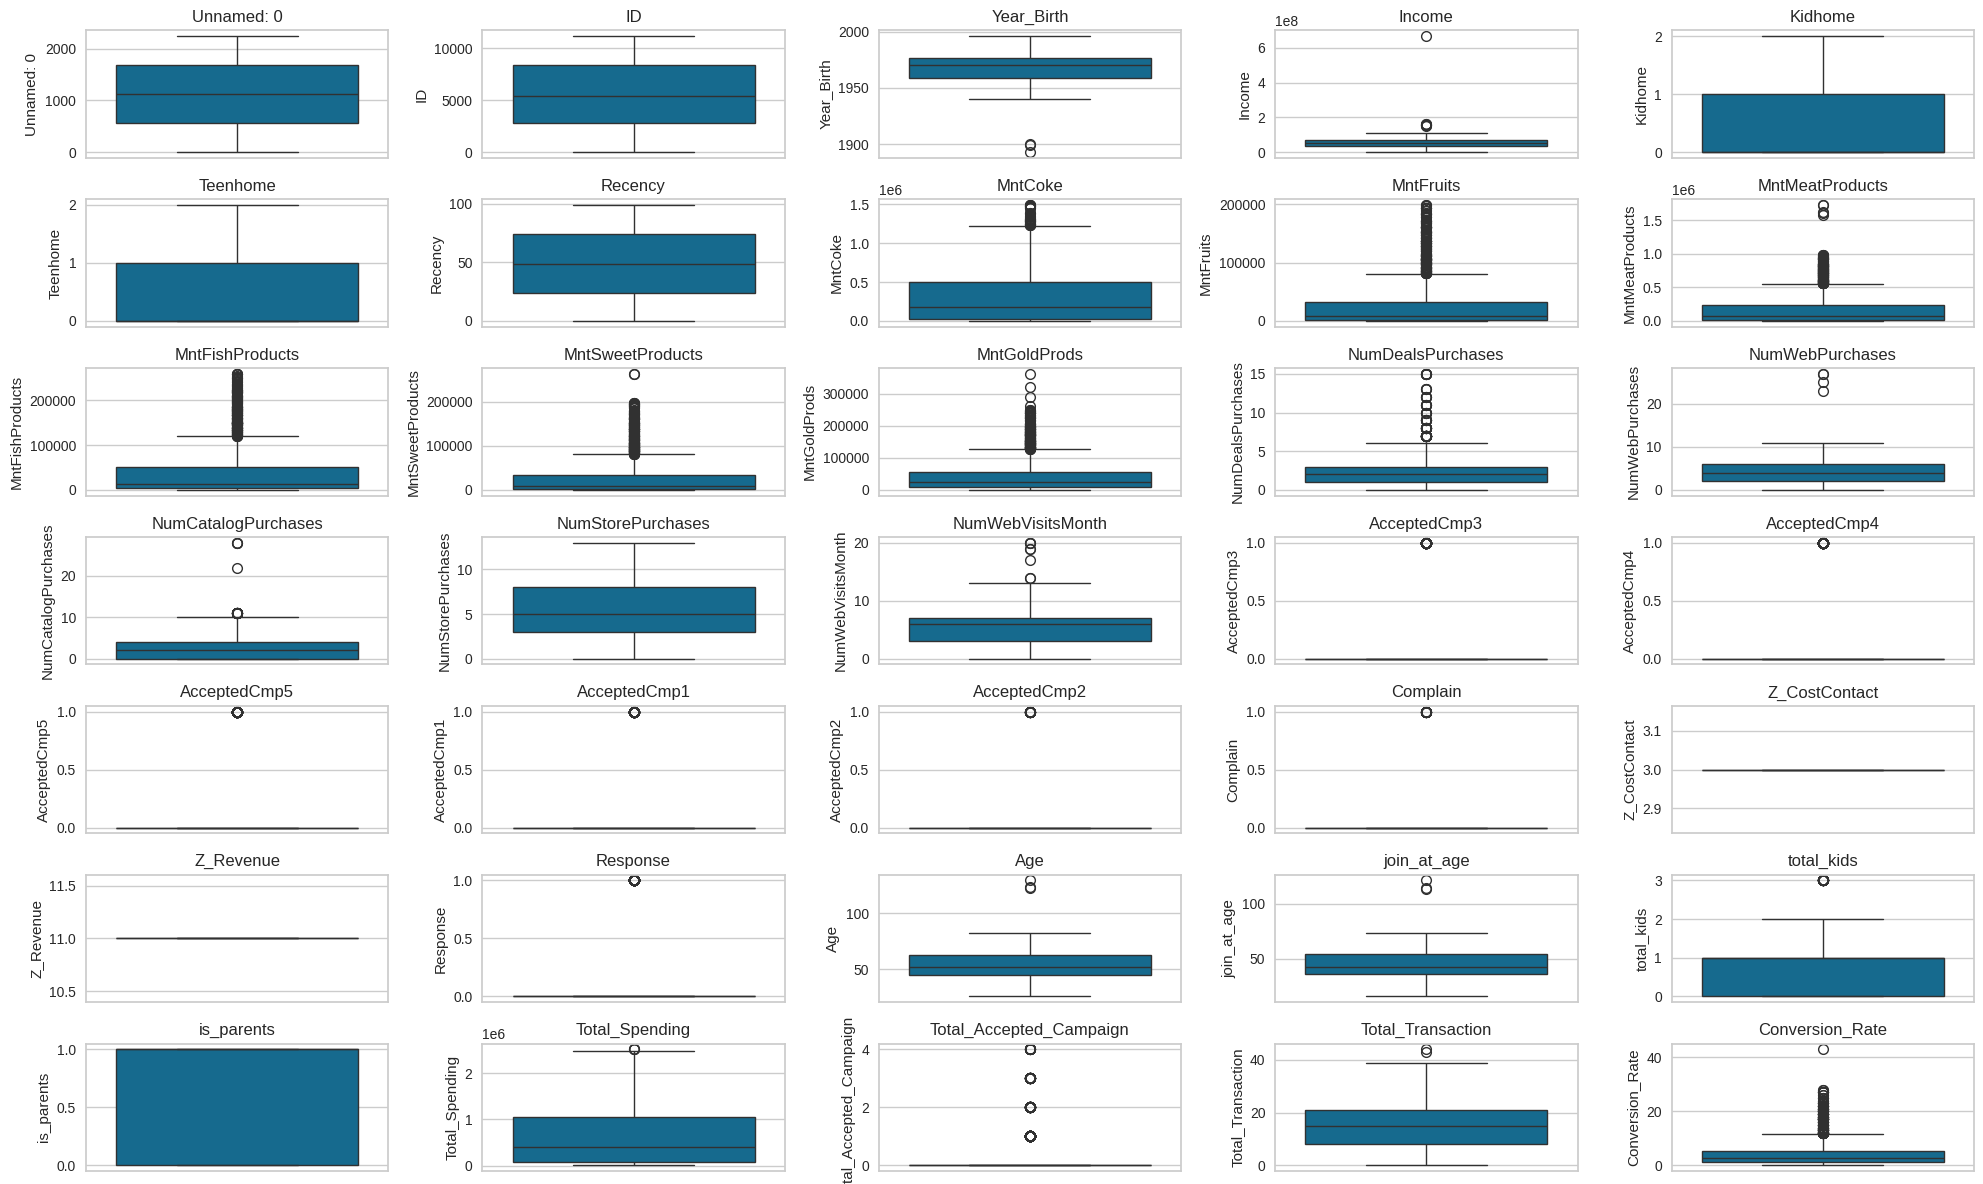

In [13]:
# Cek outlier Feature Numeric
plt.figure(figsize=(20, 12))
for i in range(len(num)):
    plt.subplot(7, 5, i + 1)
    sns.boxplot(y=df[num[i]], orient='v')
    plt.title(num[i])
    plt.tight_layout()

plt.show()

Key Takeaways:
- Data Cenderung memiliki outlier

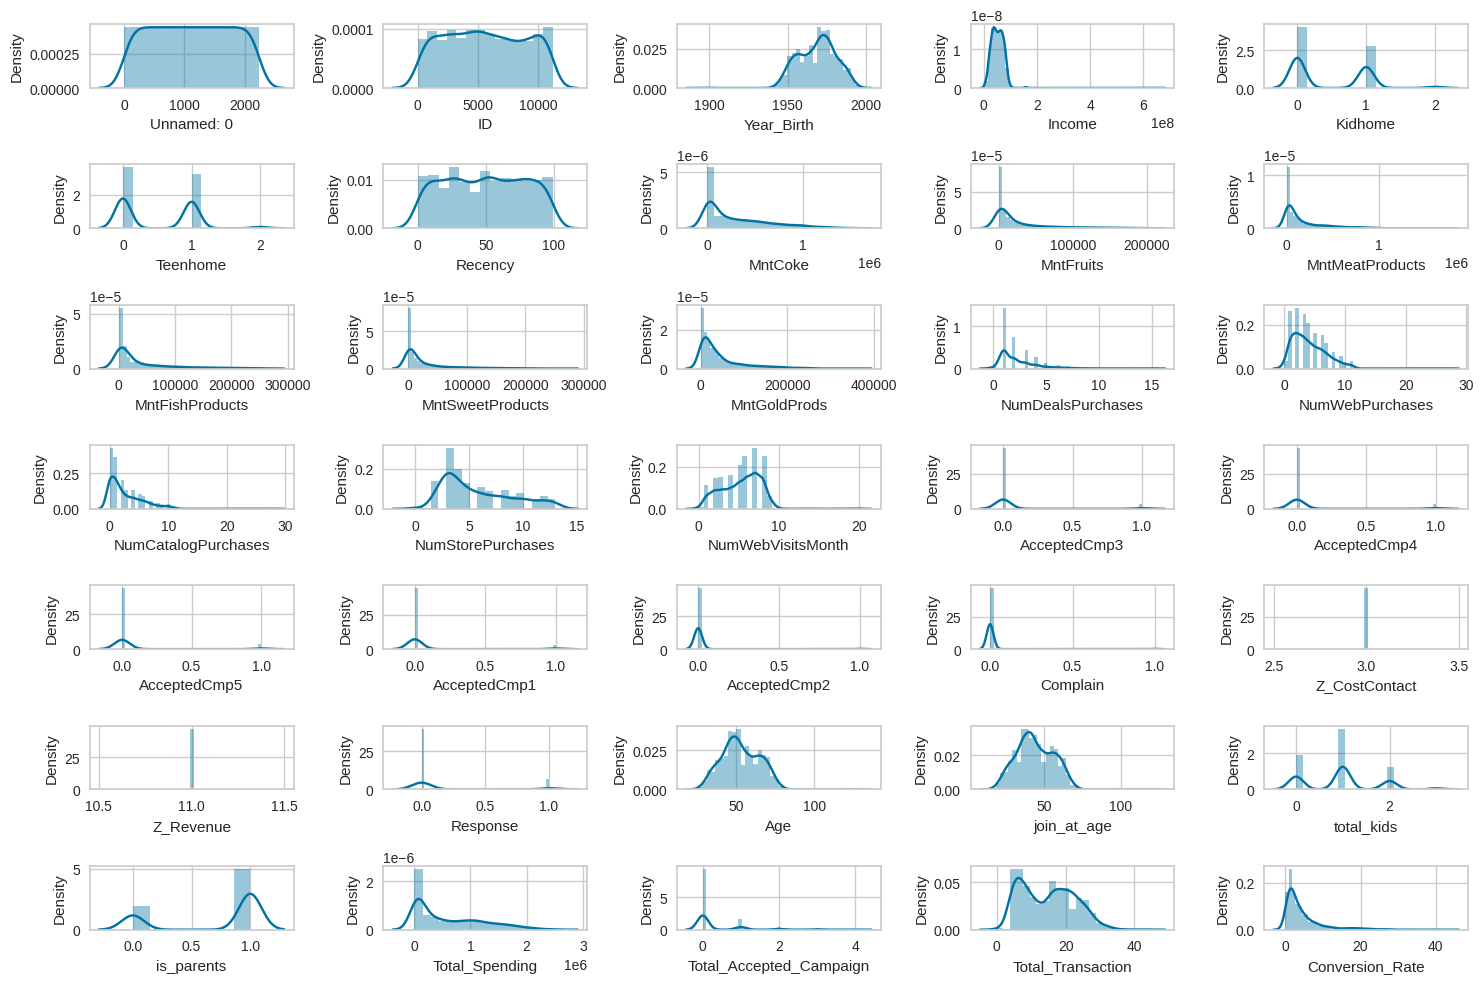

In [14]:
# Distribusi Feature Numeric
plt.figure(figsize=(15, 10))
for i in range(0, len(num)):
    plt.subplot(7, 5, i+1)
    sns.distplot(df[num[i]])
    plt.tight_layout()

Key Takeaways:
- Rata-rata fetaure berdistribusi positively skewed

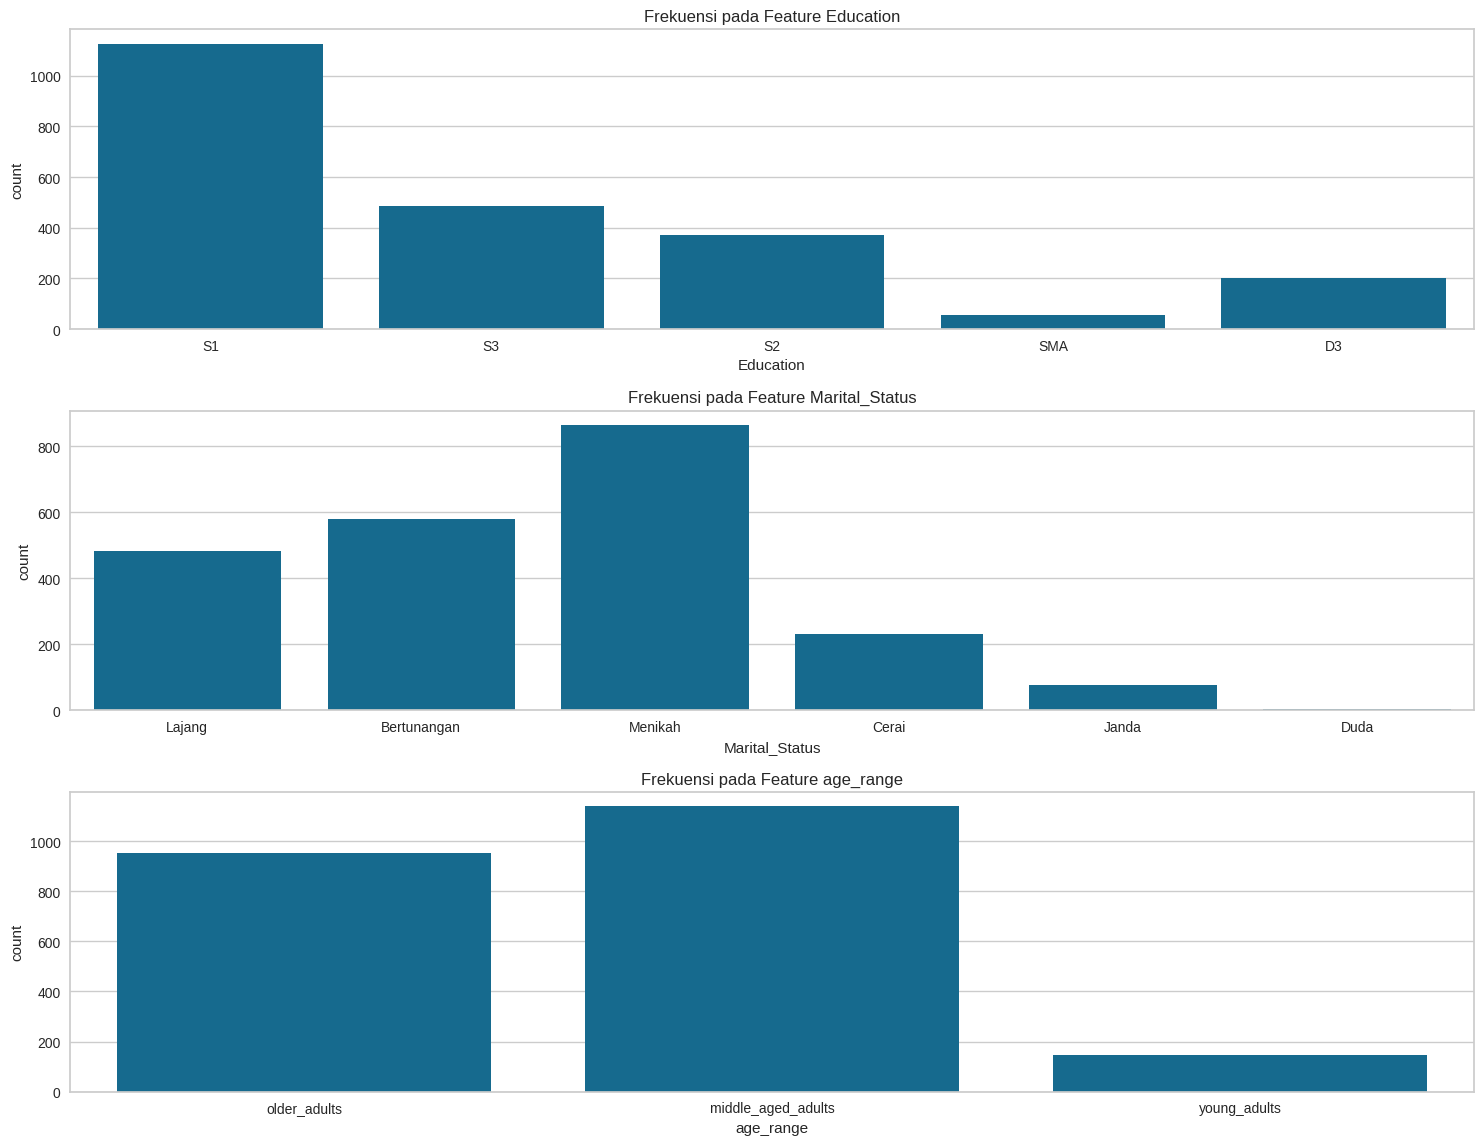

In [15]:
# Distriusi feature kategorikal
plt.figure(figsize=(15, 15))
for i in range(len(cat)):
    plt.subplot(4, 1, i+1)
    sns.countplot(x=df[cat[i]])
    plt.title(f'Frekuensi pada Feature {cat[i]}')
    plt.tight_layout()

plt.show()

Key Takeaways:
- Education di dominasi oleh S1
- Marital_status di dominasi oleh Menikah


### Multivariate Analysis

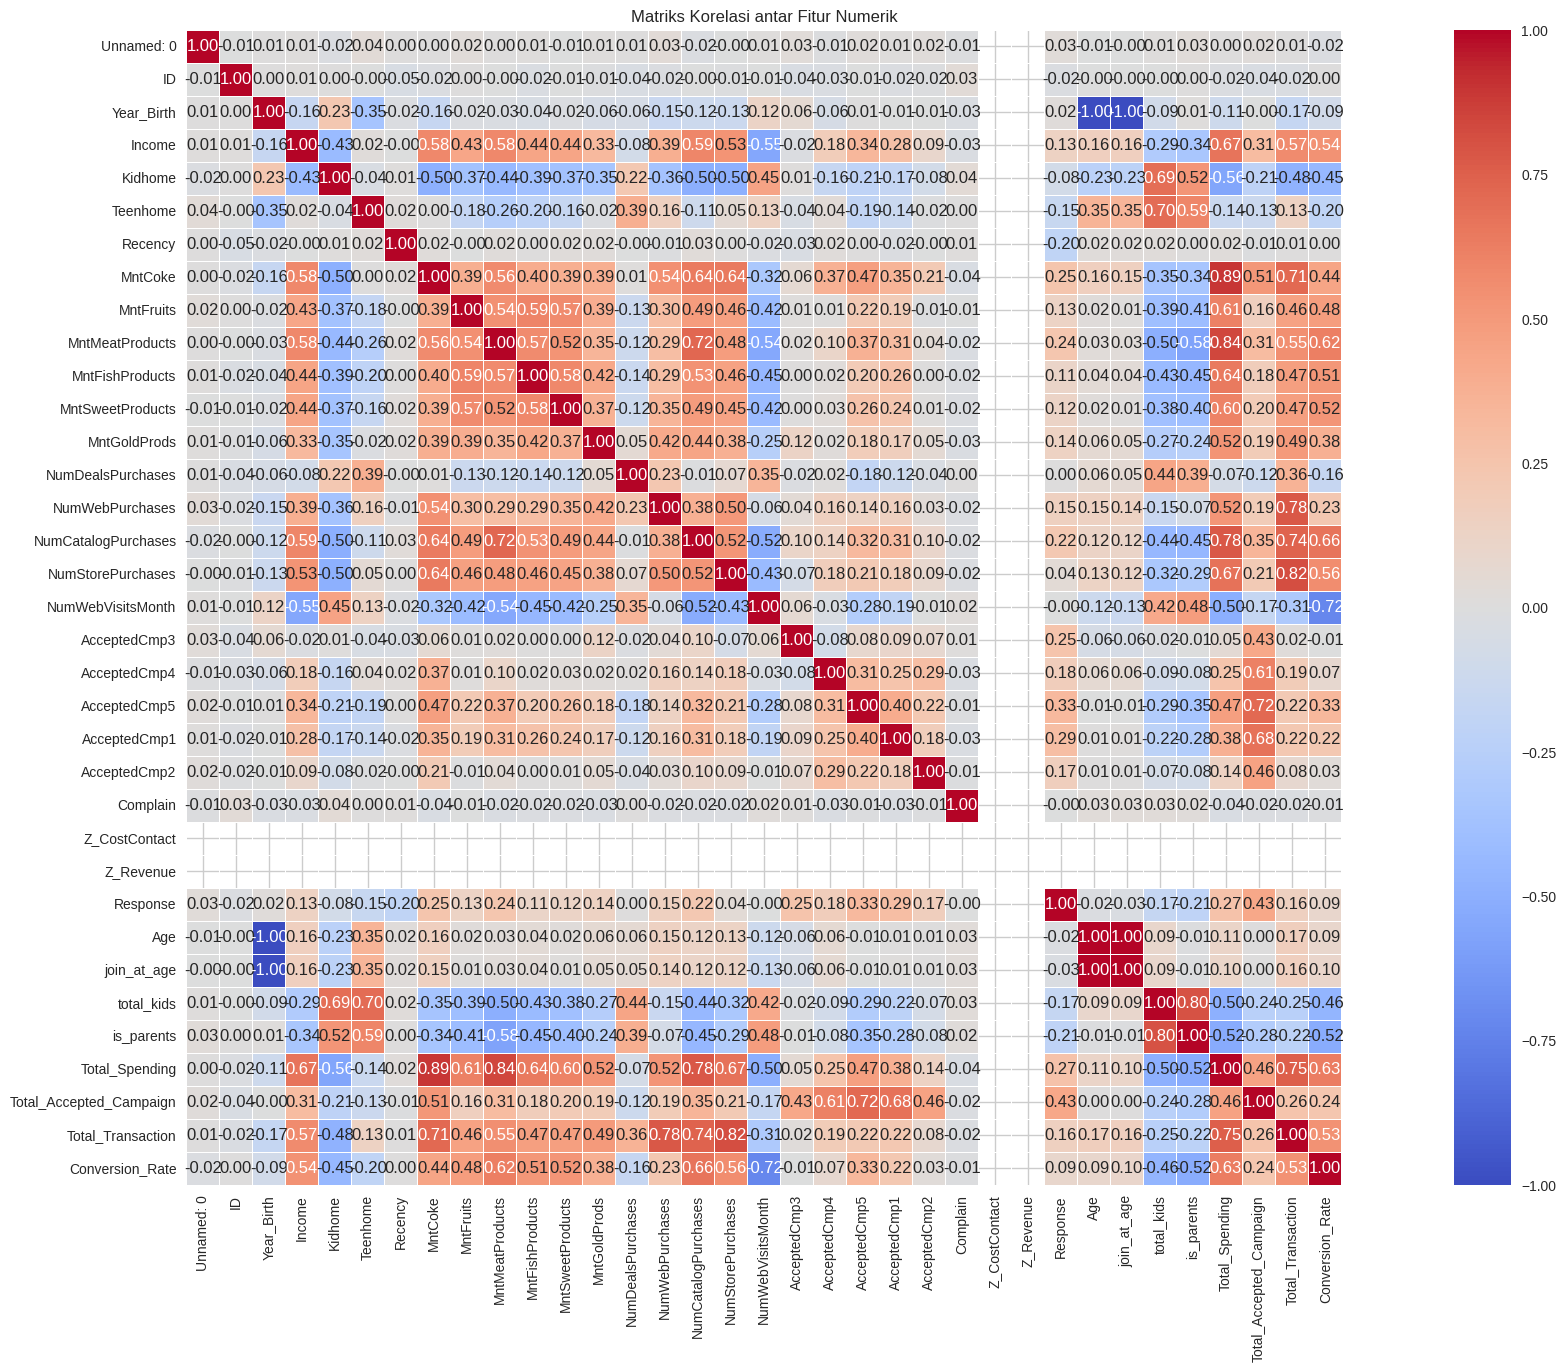

In [16]:
# Menghitung korelasi antar fitur numerik
corr_matrix = df[num].corr()

# Plotting heatmap untuk visualisasi korelasi
plt.figure(figsize=(29, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=.5)
plt.title('Matriks Korelasi antar Fitur Numerik')
plt.show()

Key Takeaways:

- Feature **MntCoke**, **MntMeatProducts**, **MntFruits**, **MntFishProducts**, **MntSweetProducts**, dan **MntGoldProds** menunjukkan korelasi positif yang kuat satu sama lain, yang menunjukkan bahwa pelanggan yang spending di satu kategori cenderung spending lebih banyak di kategori lainnya juga.

- Feature **Total_Spending** memiliki korelasi positif dengan **NumCatalogPurchases** dan **NumStorePurchases**, yang mengindikasikan bahwa pelanggan lebih banyak melakukan pembelian melalui katalog dan di toko.

- Feature **Total_Accepted_Campaigns**  memiliki korelasi positif dengan **Conversion_Rate** dan **Response**, menunjukkan bahwa pelanggan yang menerima lebih banyak penawaran cenderung memiliki tingkat konversi yang lebih tinggi.

- Feature **Age** memiliki korelasi negatif dengan **Kidhome** dan **Teenhome**, yang mungkin menunjukkan bahwa pelanggan yang lebih muda lebih cenderung memiliki anak-anak atau remaja di rumah.

- Feature **NumWebVisitsMonth** memiliki korelasi negatif dengan **Income** dan **Total_Spending**, diketahui bahwa pelanggan dengan pendapatan lebih tinggi dan pengeluaran lebih banyak cenderung mengunjungi situs web perusahaan lebih sedikit.

## b. Correlation of Conversion Rate with Income, Total Spending and Age

In [17]:
df_outlier = df.copy()
variables = ['Income', 'Total_Spending', 'Age']
for column in variables:
    Q1 = df_outlier[column].quantile(0.25)
    Q3 = df_outlier[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_outlier = df_outlier[(df_outlier[column] >= lower_bound) & (df_outlier[column] <= upper_bound)]
print(df_outlier.shape)


(2202, 39)


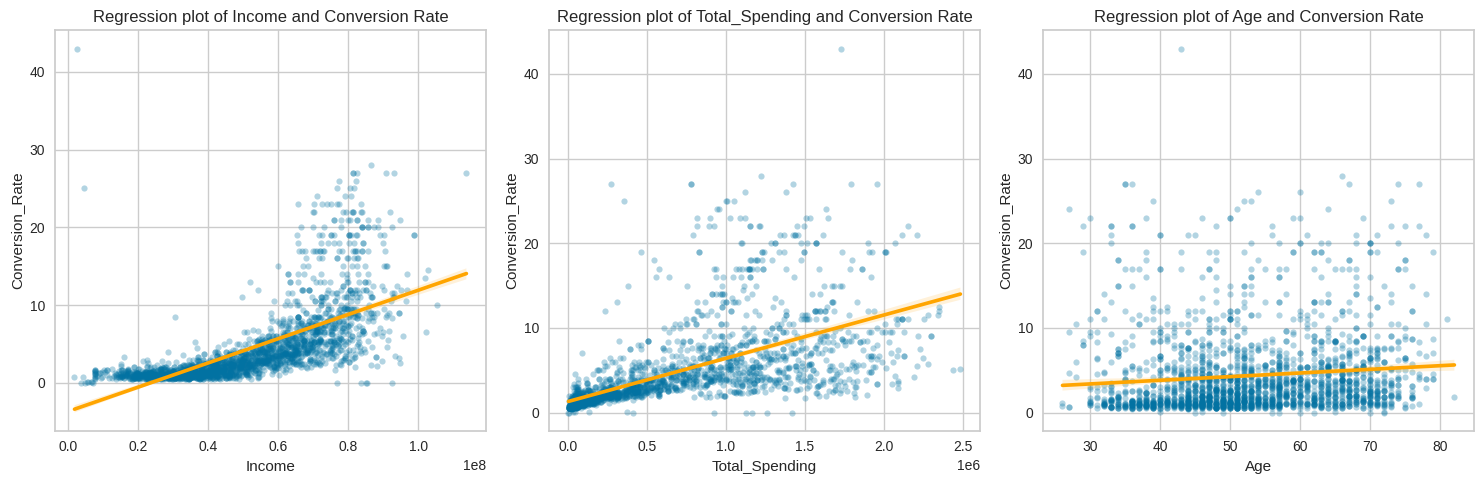

In [18]:
variables = ['Income', 'Total_Spending', 'Age']

plt.figure(figsize=(15, 5))

for var in range(0, len(variables)):
    plt.subplot(1, 3, var + 1)
    sns.regplot(x=variables[var], y='Conversion_Rate', data=df_outlier, scatter_kws={'s': 20, 'alpha': 0.3},
                line_kws={'color': 'orange'}).set(title=f'Regression plot of {variables[var]} and Conversion Rate')
    plt.tight_layout()

plt.show()

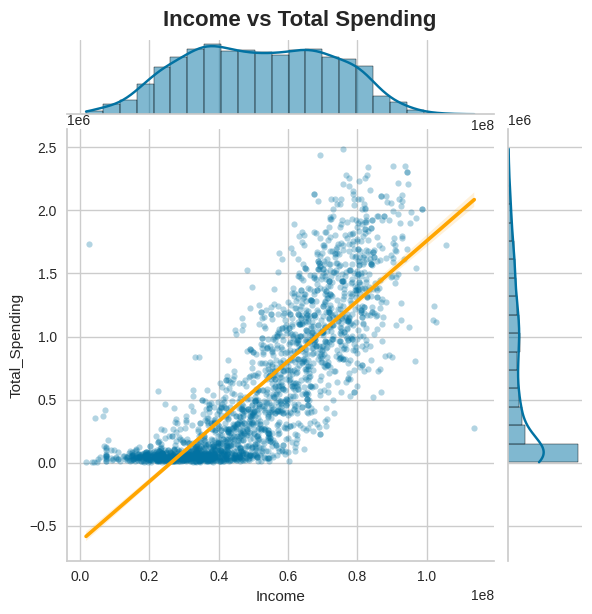

In [19]:
# Membuat joint plot untuk Income dan Total_Spending
sns.jointplot(x='Income', y='Total_Spending', data=df_outlier, kind='reg', scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'orange'})

plt.suptitle('Income vs Total Spending', y=1.02, fontsize=16, fontweight='bold')
plt.show()

# 6 Data Cleaning and Preprocessing

## Handling Missing Value

In [20]:
# Cek Missing value
df.isna().sum()

,0
Unnamed: 0,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0


- Terdapat null value pada Feature **Income** sebanyak 24 baris
- Solusi:
  - Menghapus baris null, karena jumlahnya hanya sedikit

In [21]:
df = df.dropna()

## Handling Duplicated Data

In [22]:
df.duplicated().sum()

0

## Feature Encoding

In [23]:
# Pengelompokkan Feature
num = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
      'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
      'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue',
      'Age', 'join_at_age', 'total_kids', 'Total_Spending'
     ]

cat = ['Education', 'Marital_Status',
        'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
        'AcceptedCmp4', 'AcceptedCmp5', 'Complain',
        'Response', 'is_parents', 'age_range'
      ]

In [24]:
for col in cat:
    print(f'value counts of column {col}')
    print(df[col].value_counts())
    print('---'*10, '\n')

value counts of column Education
Education
S1     1116
S3      481
S2      365
D3      200
SMA      54
Name: count, dtype: int64
------------------------------ 

value counts of column Marital_Status
Marital_Status
Menikah        857
Bertunangan    573
Lajang         475
Cerai          232
Janda           76
Duda             3
Name: count, dtype: int64
------------------------------ 

value counts of column AcceptedCmp1
AcceptedCmp1
0    2074
1     142
Name: count, dtype: int64
------------------------------ 

value counts of column AcceptedCmp2
AcceptedCmp2
0    2186
1      30
Name: count, dtype: int64
------------------------------ 

value counts of column AcceptedCmp3
AcceptedCmp3
0    2053
1     163
Name: count, dtype: int64
------------------------------ 

value counts of column AcceptedCmp4
AcceptedCmp4
0    2052
1     164
Name: count, dtype: int64
------------------------------ 

value counts of column AcceptedCmp5
AcceptedCmp5
0    2054
1     162
Name: count, dtype: int64
-----

In [25]:
# Label Encoding
# Mapping untuk fitur "Education"
mapping_education = {'SMA': 0, 'D3': 1, 'S1': 2, 'S2': 3, 'S3': 4}

df['education_encd'] = df['Education'].map(mapping_education)
df.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,Age,join_at_age,total_kids,is_parents,age_range,Total_Spending,Total_Accepted_Campaign,Total_Transaction,Conversion_Rate,education_encd
0,0,5524,1957,S1,Lajang,58138000.0,0,0,2012-09-04,58,...,65,55,0,0,older_adults,1617000,0,25,3.571429,2
1,1,2174,1954,S1,Lajang,46344000.0,1,1,2014-03-08,38,...,68,60,2,1,older_adults,27000,0,6,1.200000,2
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,2013-08-21,26,...,57,48,0,0,older_adults,776000,0,21,5.250000,2
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,2014-02-10,26,...,38,30,1,1,middle_aged_adults,53000,0,8,1.333333,2
4,4,5324,1981,S3,Menikah,58293000.0,1,0,2014-01-19,94,...,41,33,1,1,middle_aged_adults,422000,0,19,3.800000,4


## Feature Transformation

### Standardization

In [26]:
from sklearn.preprocessing import StandardScaler
df_scaled = df.copy()
ss = StandardScaler()

for col in num:
    df_scaled[col] = ss.fit_transform(df_scaled[[col]])

display(df_scaled.shape, df_scaled.head(3))

(2216, 40)

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,Age,join_at_age,total_kids,is_parents,age_range,Total_Spending,Total_Accepted_Campaign,Total_Transaction,Conversion_Rate,education_encd
0,0,5524,1957,S1,Lajang,0.234063,-0.823039,-0.928972,2012-09-04,0.310532,...,0.986443,0.897752,-1.264803,0,older_adults,1.675488,0,25,3.571429,2
1,1,2174,1954,S1,Lajang,-0.234559,1.039938,0.909066,2014-03-08,-0.380509,...,1.236801,1.313688,1.405806,1,older_adults,-0.962358,0,6,1.200000,2
2,2,4141,1965,S1,Bertunangan,0.769478,-0.823039,-0.928972,2013-08-21,-0.795134,...,0.318822,0.315443,-1.264803,0,older_adults,0.280250,0,21,5.250000,2


In [27]:
df.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,Age,join_at_age,total_kids,is_parents,age_range,Total_Spending,Total_Accepted_Campaign,Total_Transaction,Conversion_Rate,education_encd
0,0,5524,1957,S1,Lajang,58138000.0,0,0,2012-09-04,58,...,65,55,0,0,older_adults,1617000,0,25,3.571429,2
1,1,2174,1954,S1,Lajang,46344000.0,1,1,2014-03-08,38,...,68,60,2,1,older_adults,27000,0,6,1.200000,2
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,2013-08-21,26,...,57,48,0,0,older_adults,776000,0,21,5.250000,2
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,2014-02-10,26,...,38,30,1,1,middle_aged_adults,53000,0,8,1.333333,2
4,4,5324,1981,S3,Menikah,58293000.0,1,0,2014-01-19,94,...,41,33,1,1,middle_aged_adults,422000,0,19,3.800000,4


# Modelling


In [28]:
df2 = df_scaled.copy()
df3 = df2.drop(columns=['Unnamed: 0', 'ID', 'Year_Birth', 'Education', 'Marital_Status', 'age_range', 'Dt_Customer']).copy()


## Elbow Method

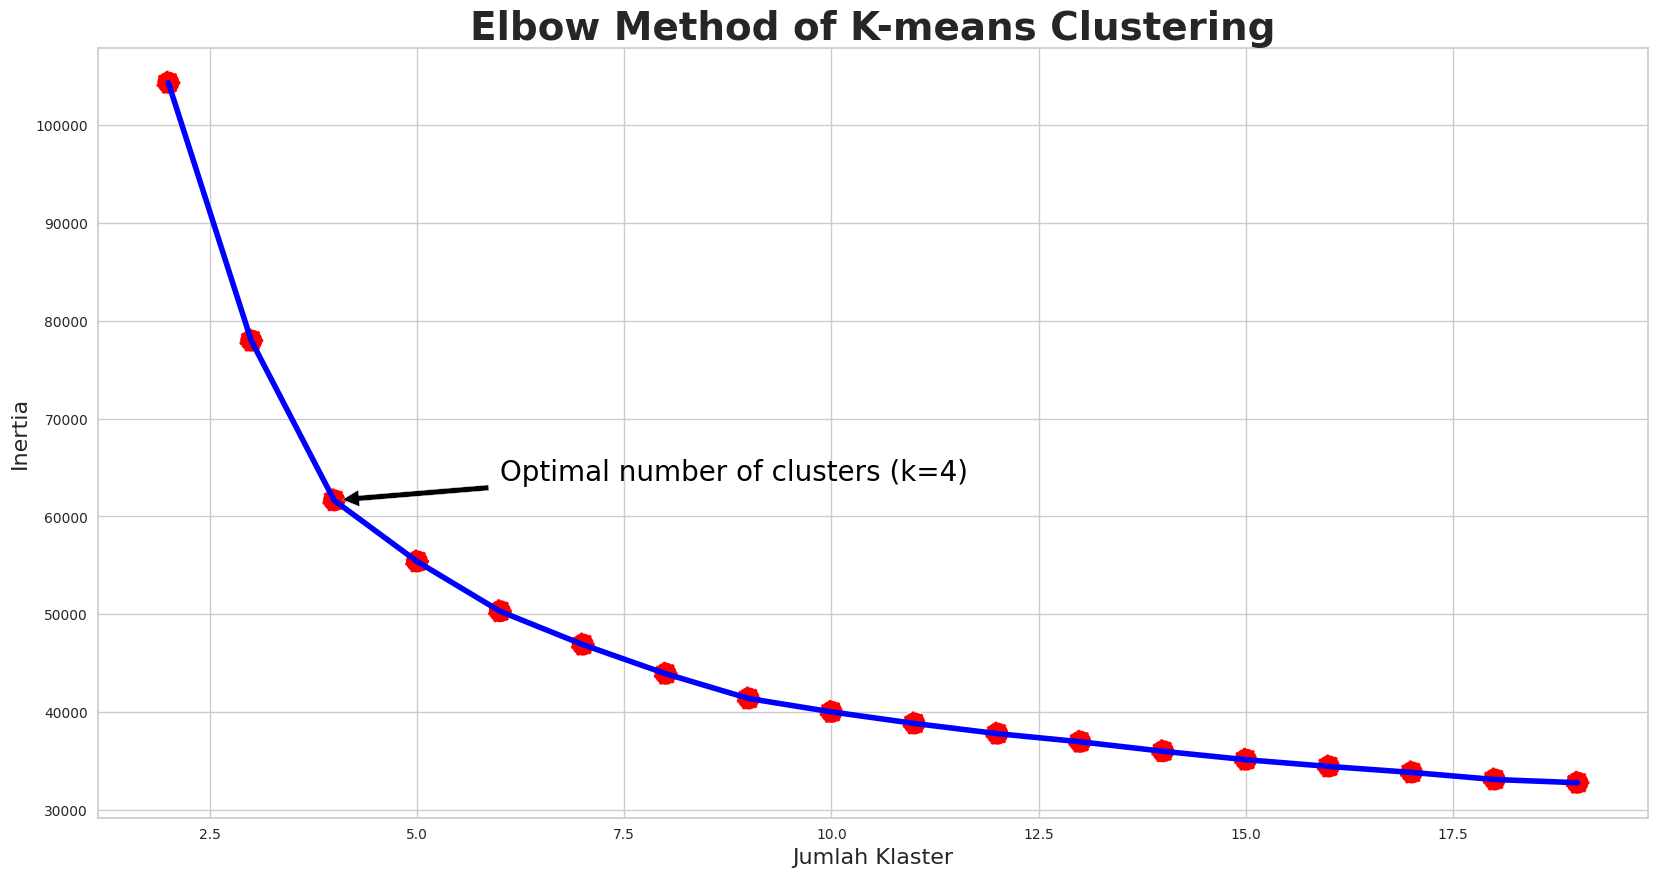

In [29]:
inertia = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df3.values)
    inertia.append(kmeans.inertia_)

# Plot hasil metode elbow
plt.figure(figsize=(20, 10))
plt.title('Elbow Method of K-means Clustering', fontsize=28, fontweight='bold')
sns.lineplot(x=range(2, 20), y=inertia, color='blue', linewidth=4)
sns.scatterplot(x=range(2, 20), y=inertia, s=300, color='red', linestyle='--')
plt.xlabel('Jumlah Klaster', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
sns.set_style("whitegrid")

# Tambahkan anotasi untuk klaster optimal
plt.annotate('Optimal number of clusters (k=4)',
             xy=(4, inertia[2]),
             xytext=(6, inertia[2] + 2000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=20,
             color='black')

plt.show()

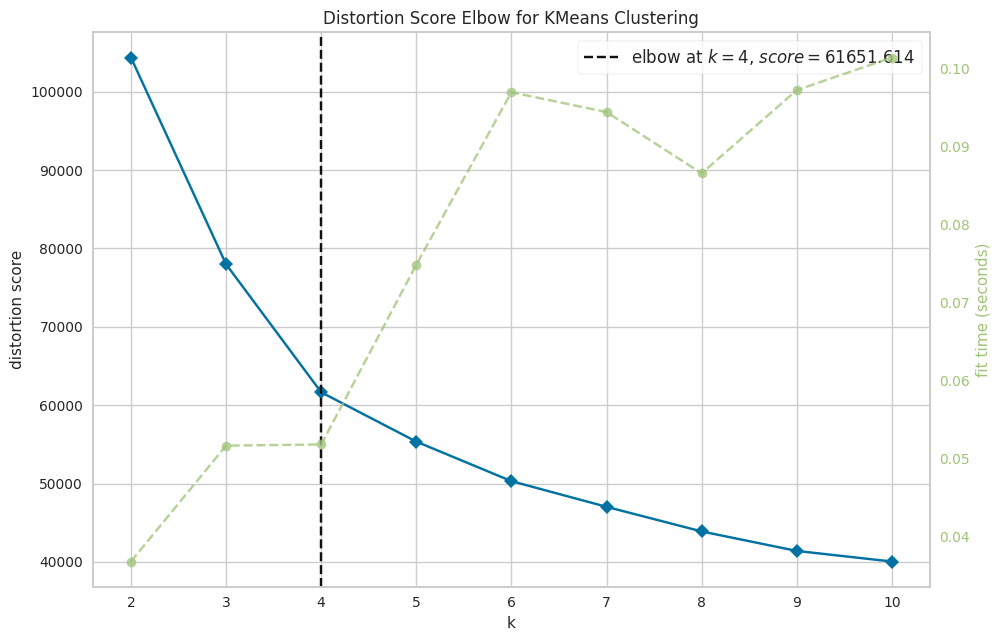

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# Distortion Score
plt.figure(figsize=(12, 10))
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, metric='distortion', timings=True, locate_elbow=True, size=(1080, 720))
visualizer.fit(df3)  # Fit data ke visualizer
visualizer.show()  # Tampilkan visualisasi


In [31]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df3.values)
df3['cluster'] = kmeans.labels_
df['cluster'] = kmeans.labels_


In [32]:
df3.tail()

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Age,join_at_age,total_kids,is_parents,Total_Spending,Total_Accepted_Campaign,Total_Transaction,Conversion_Rate,education_encd,cluster
2235,0.356642,-0.823039,0.909066,-0.104093,1.197646,0.418348,0.066913,0.079693,2.215416,3.919308,...,0.151917,0.149069,0.070501,1,1.217598,0,18,3.600000,2,2
2236,0.467539,2.902916,0.909066,0.241428,0.299208,-0.662463,-0.610954,-0.687574,-0.658233,-0.694260,...,1.904422,1.979184,2.741110,1,-0.270546,1,22,3.142857,4,1
2237,0.188091,-0.823039,-0.928972,1.450751,1.787710,0.544024,0.223001,-0.102990,-0.365998,-0.385402,...,-1.016420,-0.932363,-1.264803,0,1.051696,1,19,3.166667,2,2
2238,0.675388,-0.823039,0.909066,-1.417072,0.364441,0.091591,0.209622,0.773887,0.072356,0.328832,...,1.069896,1.147313,0.070501,1,0.391404,0,23,7.666667,3,1
2239,0.024705,1.039938,0.909066,-0.311405,-0.655568,-0.587058,-0.472705,-0.651038,-0.633880,-0.443313,...,1.236801,1.147313,1.405806,1,-0.721800,0,11,1.571429,4,0


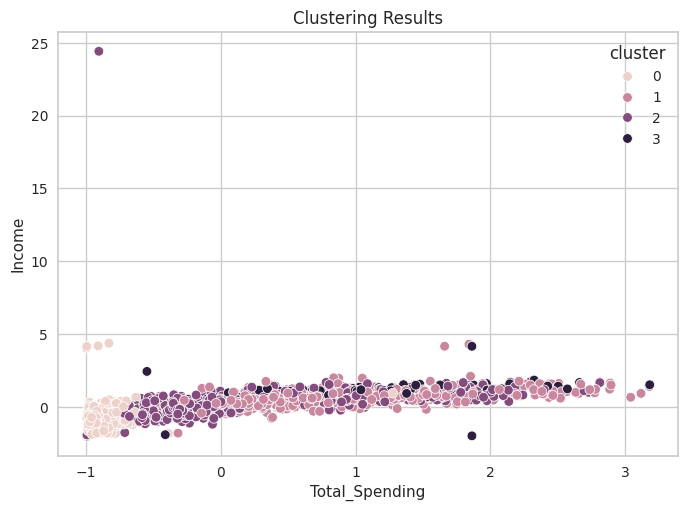

In [33]:
sns.scatterplot(data=df3, x='Total_Spending', y='Income', hue='cluster')
plt.title('Clustering Results')
plt.show()


## Silhoutte Score

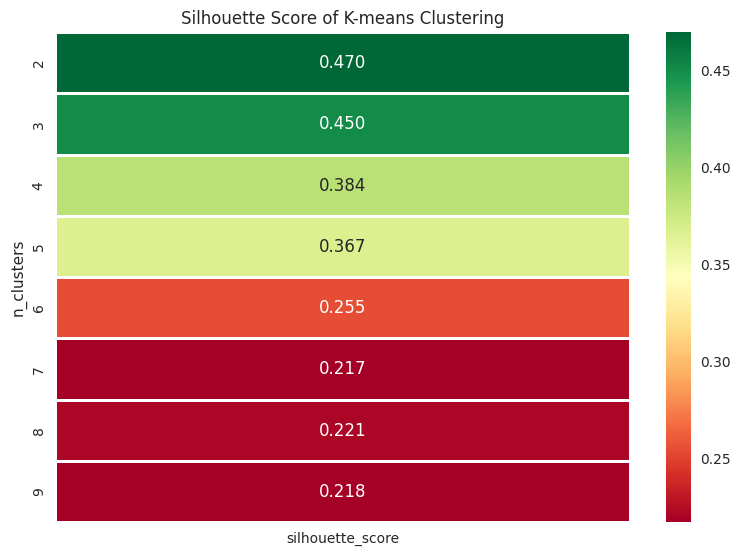

In [34]:
def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.title('Silhouette Score of K-means Clustering')
    plt.show()
visualize_silhouette_layer(df3)

# Customer personality analysis for marketing retargeting

In [35]:
df[num + ['cluster']].groupby('cluster')[['Income', 'Total_Spending']].describe()

Income                                                                 \
         count          mean           std        min         25%         50%   
cluster                                                                         
0        915.0  3.376977e+07  1.430822e+07  3502000.0  24736500.0  33402000.0   
1        564.0  6.846531e+07  1.320797e+07  7144000.0  60407500.0  68117500.0   
2        600.0  5.915598e+07  2.907067e+07  1730000.0  47159000.0  57313000.0   
3        137.0  7.863174e+07  1.416946e+07  2447000.0  72679000.0  80124000.0   

                                 Total_Spending                               \
                75%          max          count          mean            std   
cluster                                                                        
0        41020500.0  162397000.0          915.0  7.612787e+04   71647.141976   
1        76738500.0  160803000.0          564.0  1.185512e+06  444518.680991   
2        68722500.0  666666000.0          600.0  7.172950e+05  493792.719730   
3        83829000.0  157146000.0          137.0  1.289168e+06  432624.303275   

                                                              
              min       25%        50%        75%        max  
cluster                                                       
0          5000.0   36000.0    57000.0    96000.0  1376000.0  
1        415000.0  833500.0  1110500.0  1486250.0  2524000.0  
2          8000.0  346000.0   506000.0  1035250.0  2302000.0  
3        277000.0  988000.0  1216000.0  1574000.0  2525000.0

In [36]:
clusters = {
    0 : 'Risk of Churn',
    1 : 'Mid Spender',
    2 : 'Low Spender',
    3 : 'High Spender'
}

df['cluster_mapped'] = df['cluster'].map(clusters)

## Total Cluster

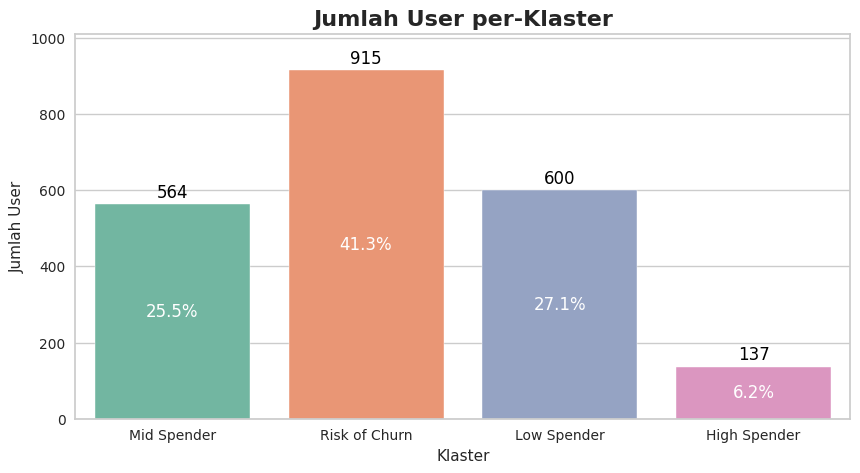

In [69]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='cluster_mapped', data=df, palette='Set2')
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total:.1f}%'
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='white')

plt.title('Jumlah User per-Klaster', fontsize=16, fontweight='bold')
plt.xlabel('Klaster')
plt.ylabel('Jumlah User')
plt.ylim(0, max(ax.get_ylim()) + 50)
plt.show()

## Total Income

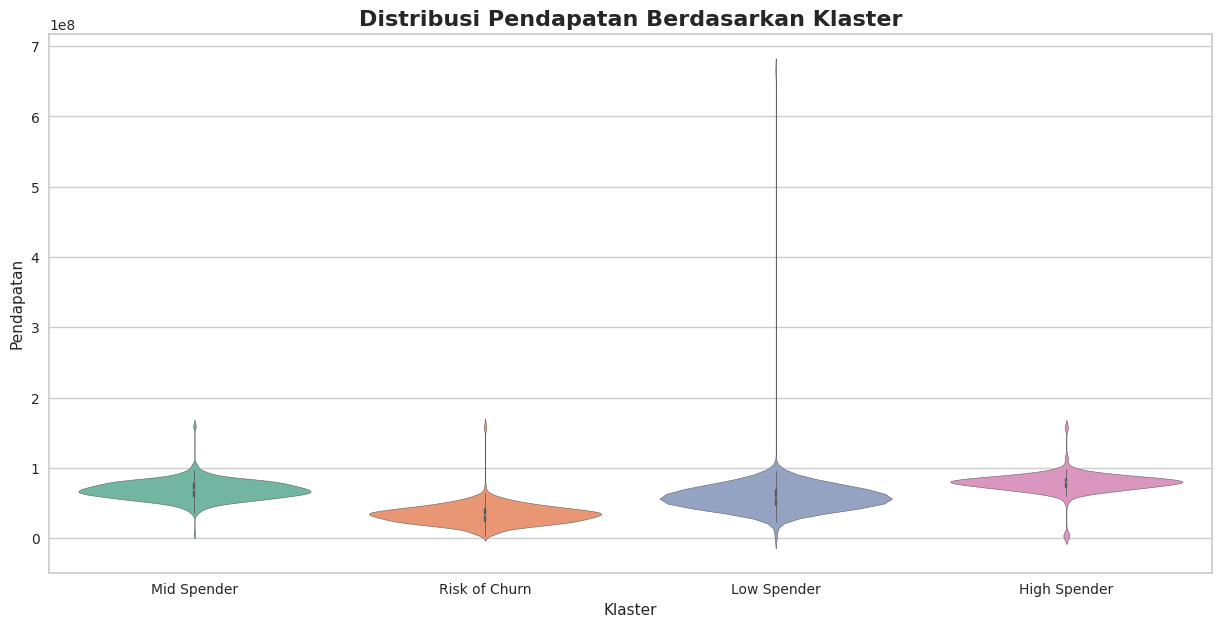

In [64]:
plt.figure(figsize=(15, 7))
sns.violinplot(x='cluster_mapped', y='Income', data=df, palette='Set2')
plt.title('Distribusi Pendapatan Berdasarkan Klaster', fontsize=16, fontweight='bold')
plt.xlabel('Klaster')
plt.ylabel('Pendapatan')
plt.show()


## Total Spending

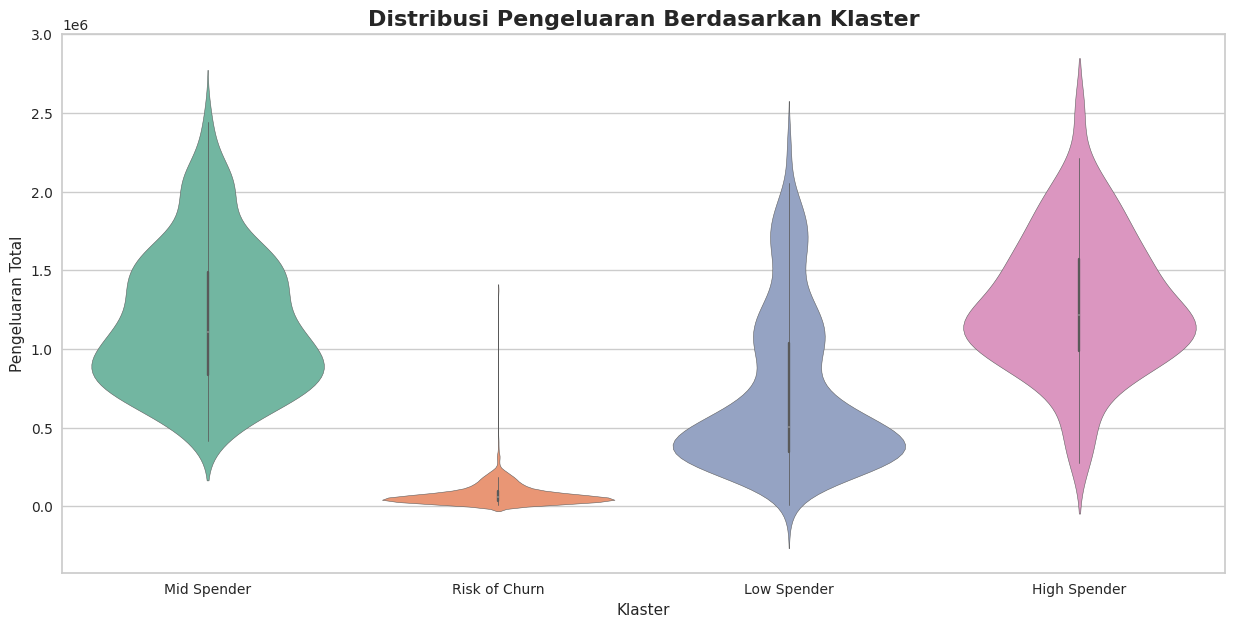

In [39]:
plt.figure(figsize=(15, 7))
sns.violinplot(x='cluster_mapped', y='Total_Spending', data=df, palette='Set2')
plt.title('Distribusi Pengeluaran Berdasarkan Klaster', fontsize=16, fontweight='bold')
plt.xlabel('Klaster')
plt.ylabel('Pengeluaran Total')
plt.show()


## Total Transaksi

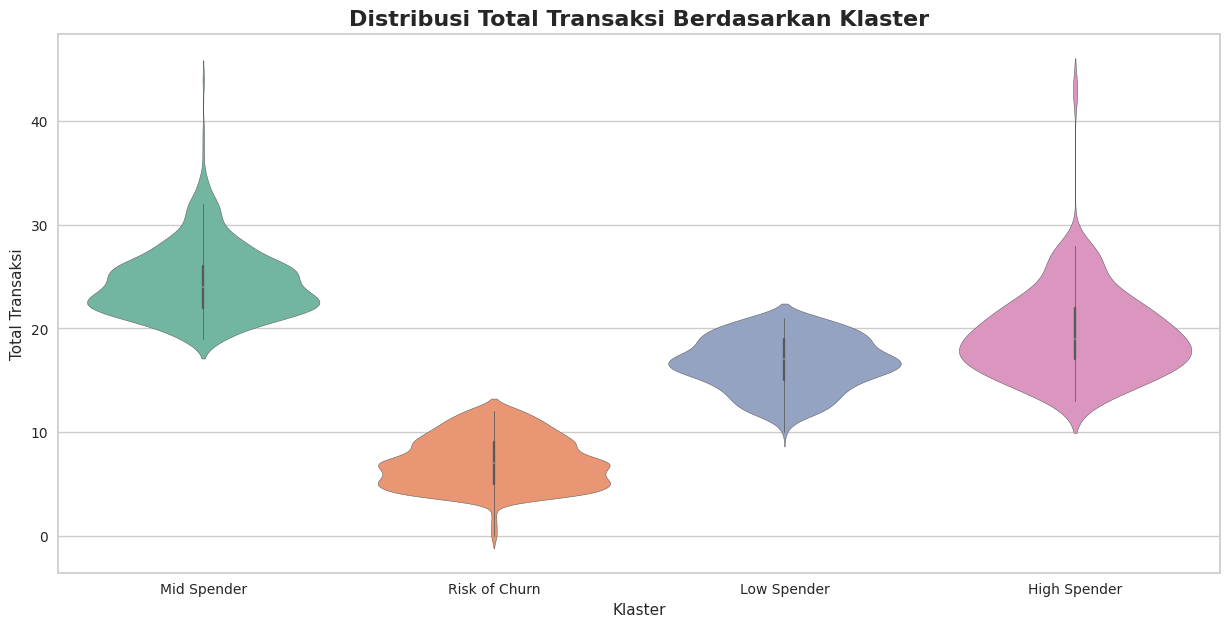

In [40]:
plt.figure(figsize=(15, 7))
sns.violinplot(x='cluster_mapped', y='Total_Transaction', data=df, palette='Set2')
plt.title('Distribusi Total Transaksi Berdasarkan Klaster', fontsize=16, fontweight='bold')
plt.xlabel('Klaster')
plt.ylabel('Total Transaksi')
plt.show()


## Conversiom Rate

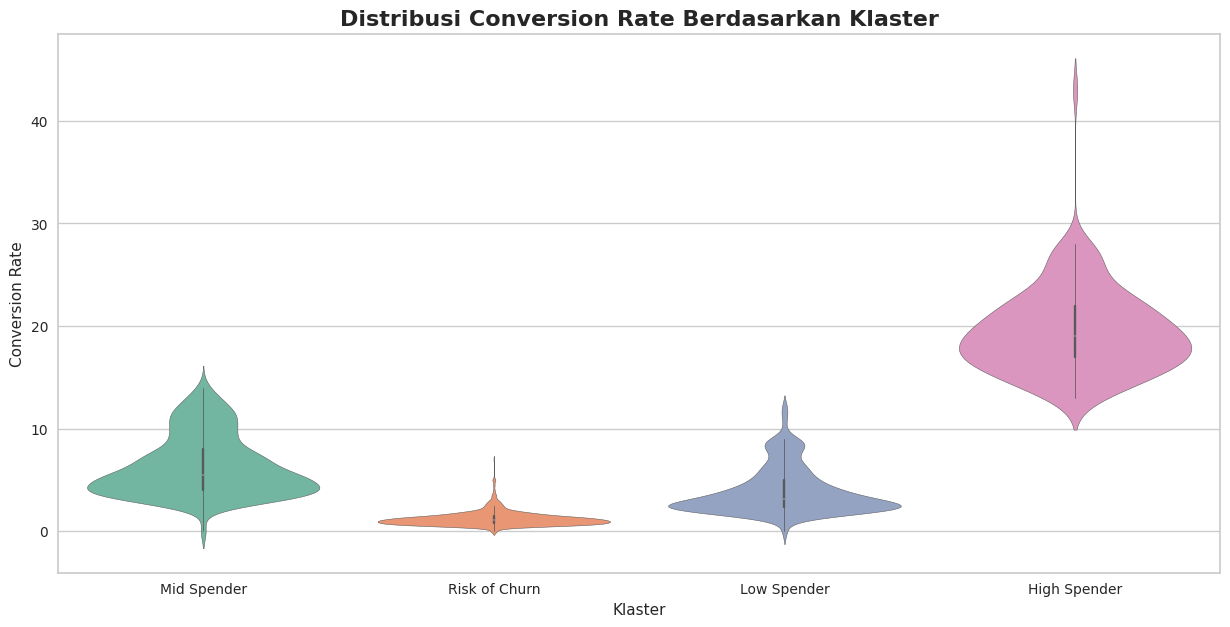

In [41]:
plt.figure(figsize=(15, 7))
sns.violinplot(x='cluster_mapped', y='Conversion_Rate', data=df, palette='Set2')
plt.title('Distribusi Conversion Rate Berdasarkan Klaster', fontsize=16, fontweight='bold')
plt.xlabel('Klaster')
plt.ylabel('Conversion Rate')
plt.show()


## Total Visit per Month

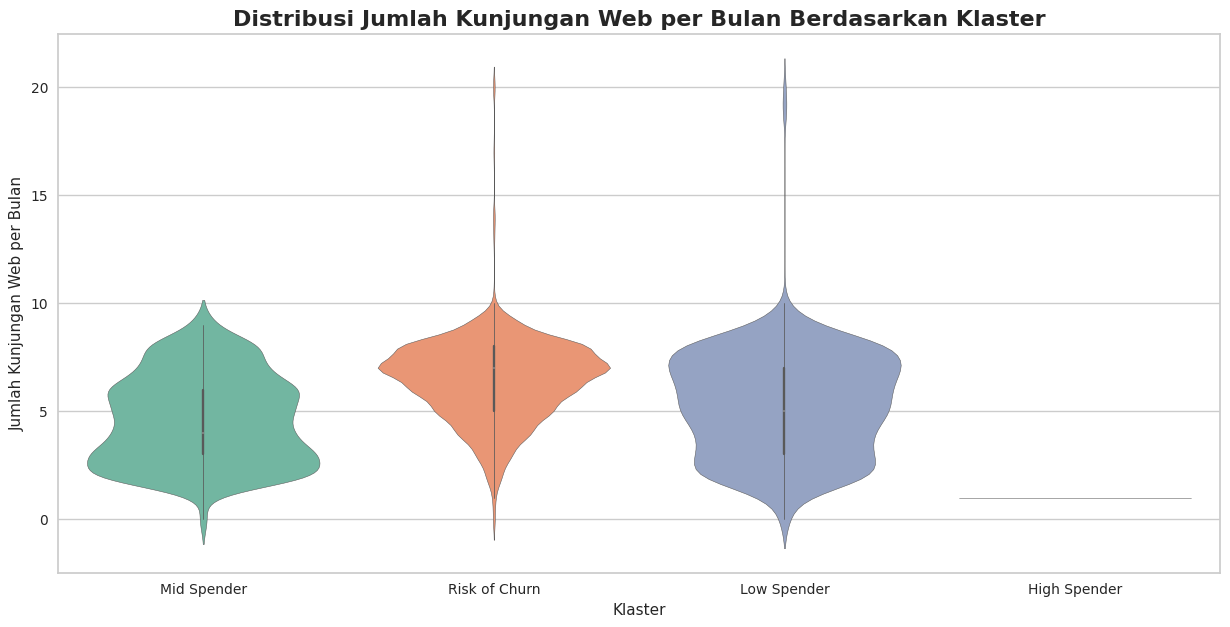

In [42]:
plt.figure(figsize=(15, 7))
sns.violinplot(x='cluster_mapped', y='NumWebVisitsMonth', data=df, palette='Set2')
plt.title('Distribusi Jumlah Kunjungan Web per Bulan Berdasarkan Klaster', fontsize=16, fontweight='bold')
plt.xlabel('Klaster')
plt.ylabel('Jumlah Kunjungan Web per Bulan')
plt.show()


## Total Csutomer by Age Category

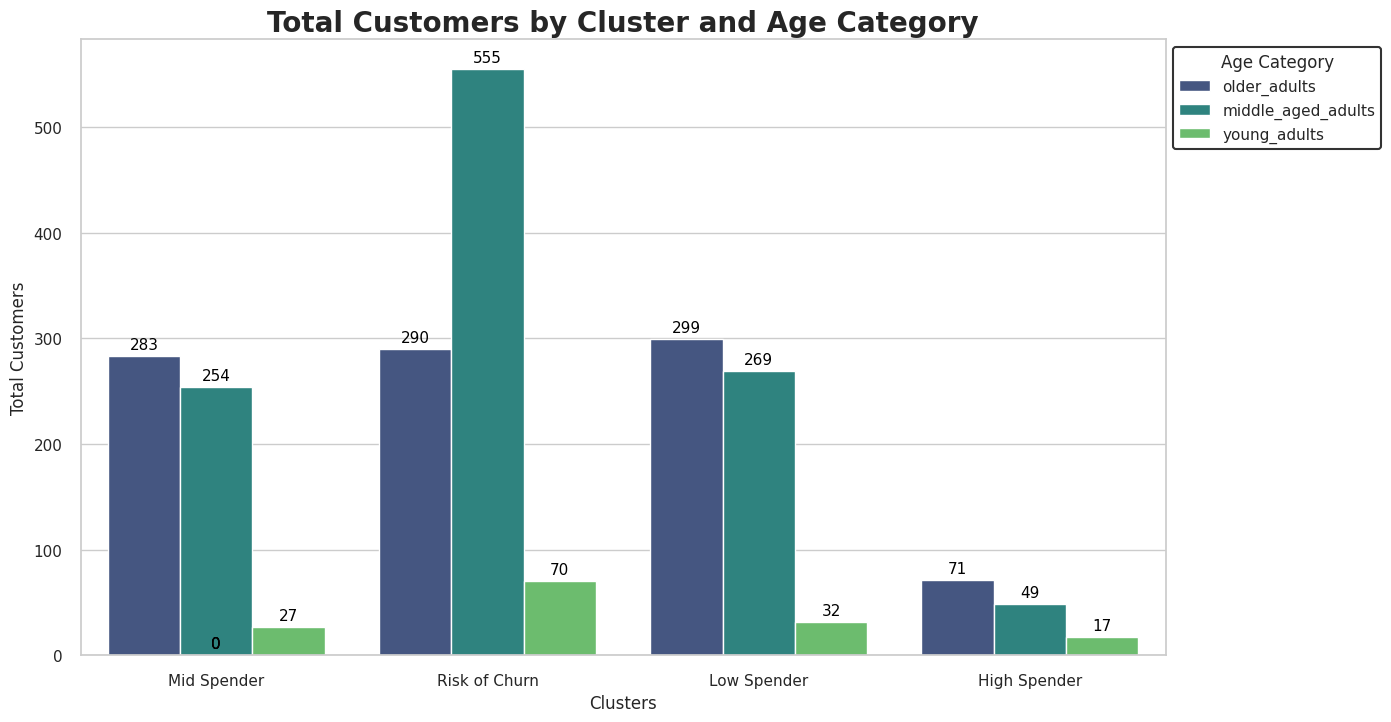

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Nama-nama klaster dan warna yang sesuai
clusters = {
    0: 'Risk of Churn',
    1: 'Mid Spender',
    2: 'Low Spender',
    3: 'High Spender'
}

# Menambahkan kolom cluster_mapped
df['cluster_mapped'] = df['cluster'].map(clusters)

# Membuat plot jumlah pengguna berdasarkan kategori umur dan klaster
plt.figure(figsize=(14, 8))
ax = sns.countplot(
    data=df,
    x='cluster_mapped',
    hue='age_range',
    palette='viridis'
)

# Menambahkan judul dan label
plt.title('Total Customers by Cluster and Age Category', fontsize=20, fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('Total Customers')

# Menambahkan anotasi jumlah pengguna di atas bar
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Menambahkan border pada legenda dan meletakkannya di luar area plot
legend = plt.legend(title='Age Category', loc='upper left', bbox_to_anchor=(1, 1), frameon=True, edgecolor='black')
legend.get_frame().set_linewidth(1.5)

# Menampilkan plot
plt.show()


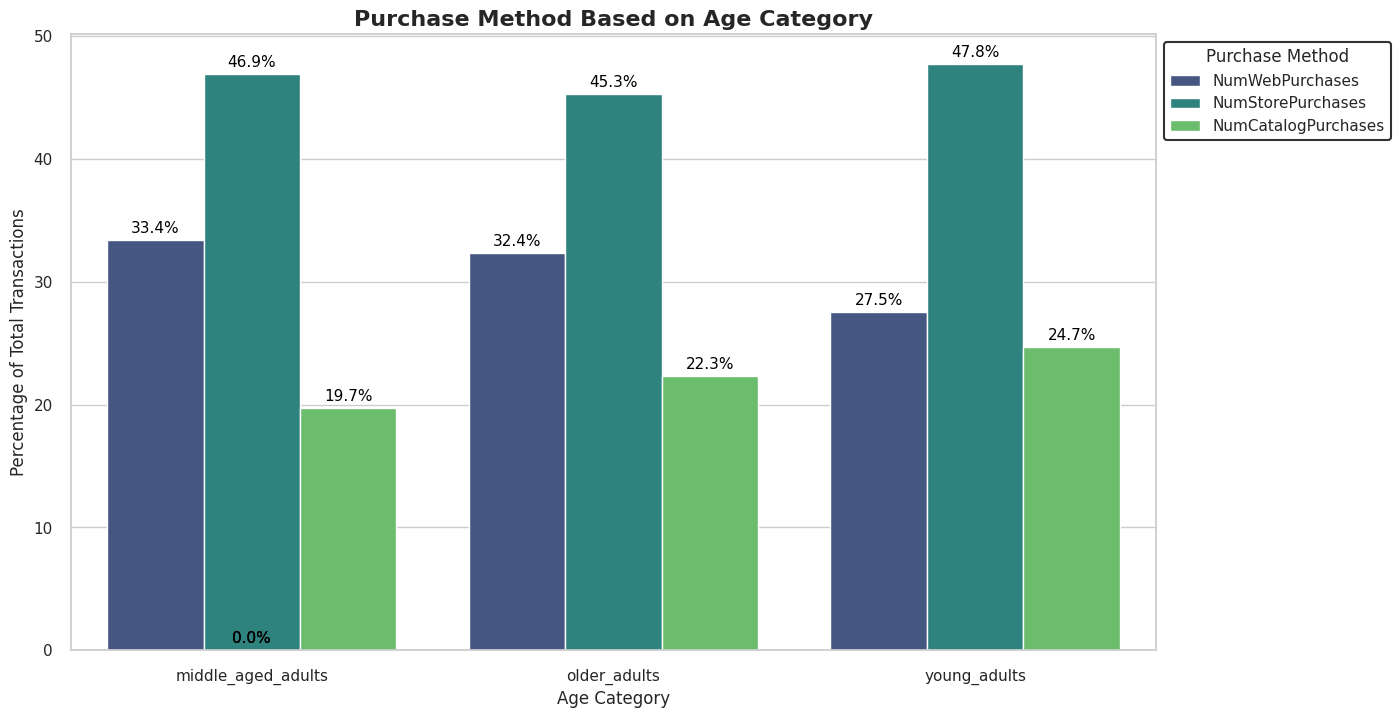

In [85]:
# Menambahkan kolom Age_Category jika belum ada
bins = [0, 24, 39, 54, 69, 100]
labels = ['Gen Z', 'Millennial', 'Gen X', 'Baby Boomer', 'Silent Generation']
df['Age_Category'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Menghitung persentase metode pembelian untuk setiap kategori usia
age_purchase = df.groupby('age_range')[['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases']].sum()
age_purchase = age_purchase.div(age_purchase.sum(axis=1), axis=0) * 100

# Membuat plot
age_purchase = age_purchase.reset_index().melt(id_vars='age_range', var_name='Purchase Method', value_name='Percentage')

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='age_range', y='Percentage', hue='Purchase Method', data=age_purchase, palette='viridis')

# Menambahkan judul dan label
plt.title('Purchase Method Based on Age Category', fontsize=16, fontweight='bold')
plt.xlabel('Age Category')
plt.ylabel('Percentage of Total Transactions')

# Menambahkan anotasi pada setiap bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Menambahkan border pada legenda dan meletakkannya di luar area plot
legend = plt.legend(title='Purchase Method', loc='upper left', bbox_to_anchor=(1, 1), frameon=True, edgecolor='black')
legend.get_frame().set_linewidth(1.5)

# Menampilkan plot
plt.show()

## Regression Plot Income Total Spending

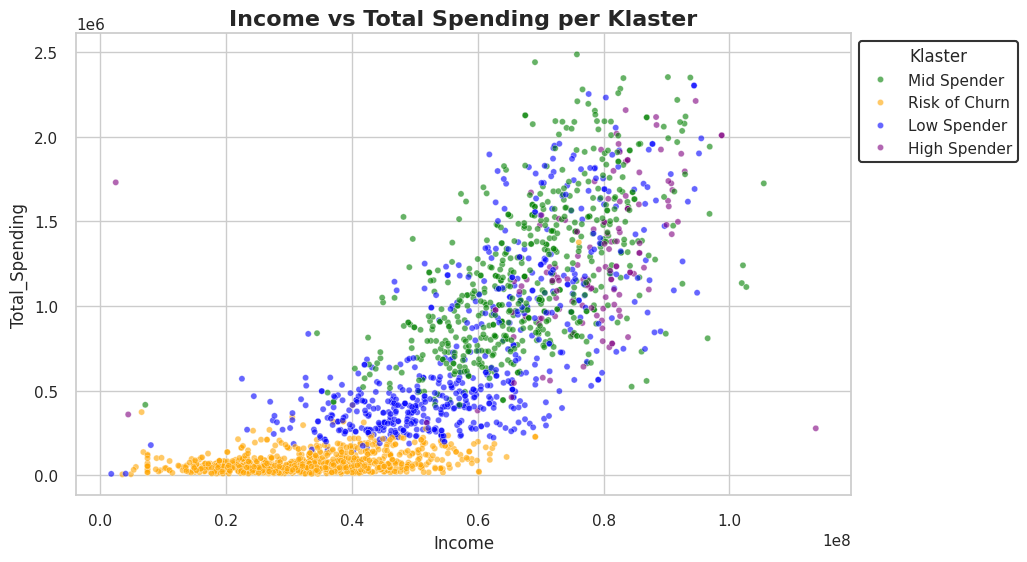

In [81]:
clusters = {
    0: 'Risk of Churn',
    1: 'Mid Spender',
    2: 'Low Spender',
    3: 'High Spender'
}

colors = {
    'Risk of Churn': 'orange',
    'Mid Spender': 'green',
    'Low Spender': 'blue',
    'High Spender': 'purple'
}
df['cluster_mapped'] = df['cluster'].map(clusters)
Q1 = df[['Income', 'Total_Spending']].quantile(0.25)
Q3 = df[['Income', 'Total_Spending']].quantile(0.75)
IQR = Q3 - Q1

df_clean = df[~((df[['Income', 'Total_Spending']] < (Q1 - 1.5 * IQR)) | (df[['Income', 'Total_Spending']] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Membuat scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x='Income',
    y='Total_Spending',
    hue='cluster_mapped',
    palette=colors,
    s=20,
    alpha=0.6
)

plt.title('Income vs Total Spending per Klaster', fontsize=16, fontweight='bold')
legend = plt.legend(title='Klaster', loc='upper left', bbox_to_anchor=(1, 1), frameon=True, edgecolor='black')
legend.get_frame().set_linewidth(1.5)
plt.show()

In [66]:
import pandas as pd

# Nama-nama klaster
clusters = {
    0: 'Risk of Churn',
    1: 'Mid Spender',
    2: 'Low Spender',
    3: 'High Spender'
}

# Pastikan kolom cluster_mapped ada di df
df['cluster_mapped'] = df['cluster'].map(clusters)

# Kolom yang akan dideskripsikan
columns_to_describe = ['Income', 'Total_Spending', 'Total_Transaction', 'Conversion_Rate', 'Age']

# Mengelompokkan berdasarkan cluster_mapped dan mendeskripsikan kolom yang dipilih
description = df.groupby('cluster_mapped')[columns_to_describe].describe()

# Menampilkan deskripsi statistik
print(description)


               Income                                                     \
                count          mean           std        min         25%   
cluster_mapped                                                             
High Spender    137.0  7.863174e+07  1.416946e+07  2447000.0  72679000.0   
Low Spender     600.0  5.915598e+07  2.907067e+07  1730000.0  47159000.0   
Mid Spender     564.0  6.846531e+07  1.320797e+07  7144000.0  60407500.0   
Risk of Churn   915.0  3.376977e+07  1.430822e+07  3502000.0  24736500.0   

                                                    Total_Spending  \
                       50%         75%          max          count   
cluster_mapped                                                       
High Spender    80124000.0  83829000.0  157146000.0          137.0   
Low Spender     57313000.0  68722500.0  666666000.0          600.0   
Mid Spender     68117500.0  76738500.0  160803000.0          564.0   
Risk of Churn   33402000.0  41020500.0  1623970

- Cluster: Risk of Churn
  - Demografi: Kelompok ini didominasi oleh middle-aged adults (36-55 tahun) dan older adults (>55 tahun), dengan rata-rata usia 50.44 tahun.
  
  - Pendapatan: Rata-rata pendapatan tahunan sebesar IDR 33.77 juta, dengan pengeluaran tahunan rata-rata IDR 76.13 ribu dan jumlah transaksi rata-rata per tahun adalah 1.23 transaksi.

  - Tingkat Konversi: Tingkat konversi rendah, dengan rata-rata 1.23%. Kelompok ini memiliki risiko tinggi untuk churn karena pengeluaran dan tingkat konversi yang rendah.

- Cluster: Low Spender
  - Demografi: Kelompok ini didominasi oleh middle-aged adults (36-55 tahun) dan older adults (>55 tahun), dengan rata-rata usia 54.87 tahun.

  - Pendapatan: Rata-rata pendapatan tahunan sebesar IDR 59.16 juta, dengan pengeluaran tahunan rata-rata IDR 717.30 ribu dan jumlah transaksi rata-rata per tahun adalah 3.93 transaksi.

  - Tingkat Konversi: Tingkat konversi rendah, dengan rata-rata 3.93%. Kelompok ini memiliki potensi untuk meningkatkan pengeluaran dengan strategi yang tepat.

- Cluster: Mid Spender
  - Demografi: Kelompok ini didominasi oleh middle-aged adults (36-55 tahun) dan older adults (>55 tahun), dengan rata-rata usia 55.30 tahun.

  - Pendapatan: Rata-rata pendapatan tahunan sebesar IDR 68.47 juta, dengan pengeluaran tahunan rata-rata IDR 1.19 juta dan jumlah transaksi rata-rata per tahun adalah 6.36 transaksi.

  - Tingkat Konversi: Tingkat konversi cukup tinggi, dengan rata-rata 6.36%. Kelompok ini memiliki potensi untuk ditingkatkan menjadi High Spender dengan strategi yang tepat.

- Cluster: High Spender
  - Demografi: Kelompok ini didominasi oleh middle-aged adults (36-55 tahun) dan older adults (>55 tahun), dengan rata-rata usia 55.30 tahun.

  - Pendapatan: Rata-rata pendapatan tahunan sebesar IDR 78.63 juta, dengan pengeluaran tahunan rata-rata IDR 1.29 juta dan jumlah transaksi rata-rata per tahun adalah 19.42 transaksi.

  - Tingkat Konversi: Tingkat konversi sangat tinggi, dengan rata-rata 19.42%. Kelompok ini adalah pelanggan dengan nilai tinggi yang perlu dipertahankan dengan layanan premium dan program loyalitas.

# Conclusion

**Recommendation**

- Tingkatkan minat pembelian user pada kelompok risk to churn. Berikan penawaran-penawarn dalam bentuk promosi, voucher atau memberikan rekomendasi produk secara personal berdasarkan  riwayat pencarian dan transaksi.`

- Melakukan pemantauan transaksi pada kelompok Low Spender,  fokus pada peningkatan penawaran melalui promosi yang dipersonalisasi sesuai dengan riwayat transaksi dan kategori produk untuk mendorong pembelian yang lebih banyak.

- Melakukan pemantauan secara rutin transaksi dan kepuasan pada kelompok High Spender. Fokus pada peningkatan layanan dan berikan reward eksklusif untuk memastikan mereka tetap bertransaksi di palform kita.


In [90]:
import pandas as pd

# Perhitungan Total GMV dan Rata-rata GMV per Transaksi untuk setiap klaster

# Total GMV oleh Risk of Churn (cluster 0)
total_gmv_risk_of_churn = df[df.cluster == 0]['Total_Spending'].sum()
avg_gmv_per_transaction_risk_of_churn = total_gmv_risk_of_churn / df[df.cluster == 0]['Total_Transaction'].sum()

# Total GMV oleh Mid Spender (cluster 1)
total_gmv_mid_spender = df[df.cluster == 1]['Total_Spending'].sum()
avg_gmv_per_transaction_mid_spender = total_gmv_mid_spender / df[df.cluster == 1]['Total_Transaction'].sum()

# Total GMV oleh Low Spender (cluster 2)
total_gmv_low_spender = df[df.cluster == 2]['Total_Spending'].sum()
avg_gmv_per_transaction_low_spender = total_gmv_low_spender / df[df.cluster == 2]['Total_Transaction'].sum()

# Total GMV oleh High Spender (cluster 3)
total_gmv_high_spender = df[df.cluster == 3]['Total_Spending'].sum()
avg_gmv_per_transaction_high_spender = total_gmv_high_spender / df[df.cluster == 3]['Total_Transaction'].sum()

# Buat DataFrame untuk Menyimpan Hasil

# Buat dictionary dengan hasil perhitungan
data = {
    'Cluster': ['Risk of Churn', 'Mid Spender', 'Low Spender', 'High Spender'],
    'Total GMV': [total_gmv_risk_of_churn, total_gmv_mid_spender, total_gmv_low_spender, total_gmv_high_spender],
    'Average GMV per Transaction': [
        avg_gmv_per_transaction_risk_of_churn,
        avg_gmv_per_transaction_mid_spender,
        avg_gmv_per_transaction_low_spender,
        avg_gmv_per_transaction_high_spender
    ]
}

# Buat DataFrame
df_gmv = pd.DataFrame(data)

# Tampilkan DataFrame
print(df_gmv)


         Cluster  Total GMV  Average GMV per Transaction
0  Risk of Churn   69657000                 10708.224443
1    Mid Spender  668629000                 48304.363531
2    Low Spender  430377000                 43175.862761
3   High Spender  176616000                 66372.040586


In [92]:
import pandas as pd

# Perhitungan Total GMV dan Rata-rata GMV per Transaksi untuk setiap klaster
total_gmv_risk_of_churn = df[df.cluster == 0]['Total_Spending'].sum()
avg_gmv_per_transaction_risk_of_churn = total_gmv_risk_of_churn / df[df.cluster == 0]['Total_Transaction'].sum()

total_gmv_mid_spender = df[df.cluster == 1]['Total_Spending'].sum()
avg_gmv_per_transaction_mid_spender = total_gmv_mid_spender / df[df.cluster == 1]['Total_Transaction'].sum()

total_gmv_low_spender = df[df.cluster == 2]['Total_Spending'].sum()
avg_gmv_per_transaction_low_spender = total_gmv_low_spender / df[df.cluster == 2]['Total_Transaction'].sum()

total_gmv_high_spender = df[df.cluster == 3]['Total_Spending'].sum()
avg_gmv_per_transaction_high_spender = total_gmv_high_spender / df[df.cluster == 3]['Total_Transaction'].sum()

# Hitung potensi penghematan jika optimasi promo pada setiap klaster dengan asumsi reduksi 50%
potensi_penghematan_risk_of_churn = (df[df.cluster == 0]['Total_Spending'].sum() / df[df.cluster == 0]['Total_Transaction'].sum()) * df[df.cluster == 0]['NumDealsPurchases'].sum()
penghematan_50_persen_risk_of_churn = potensi_penghematan_risk_of_churn * 0.5

potensi_penghematan_mid_spender = (df[df.cluster == 1]['Total_Spending'].sum() / df[df.cluster == 1]['Total_Transaction'].sum()) * df[df.cluster == 1]['NumDealsPurchases'].sum()
penghematan_50_persen_mid_spender = potensi_penghematan_mid_spender * 0.5

potensi_penghematan_low_spender = (df[df.cluster == 2]['Total_Spending'].sum() / df[df.cluster == 2]['Total_Transaction'].sum()) * df[df.cluster == 2]['NumDealsPurchases'].sum()
penghematan_50_persen_low_spender = potensi_penghematan_low_spender * 0.5

potensi_penghematan_high_spender = (df[df.cluster == 3]['Total_Spending'].sum() / df[df.cluster == 3]['Total_Transaction'].sum()) * df[df.cluster == 3]['NumDealsPurchases'].sum()
penghematan_50_persen_high_spender = potensi_penghematan_high_spender * 0.5

# Buat dictionary dengan hasil perhitungan penghematan
penghematan_data = {
    'Cluster': ['Risk of Churn', 'Mid Spender', 'Low Spender', 'High Spender'],
    'Potential Savings': [
        potensi_penghematan_risk_of_churn,
        potensi_penghematan_mid_spender,
        potensi_penghematan_low_spender,
        potensi_penghematan_high_spender
    ],
    'Savings (50%)': [
        penghematan_50_persen_risk_of_churn,
        penghematan_50_persen_mid_spender,
        penghematan_50_persen_low_spender,
        penghematan_50_persen_high_spender
    ]
}

# Buat DataFrame
df_penghematan = pd.DataFrame(penghematan_data)

# Tampilkan DataFrame dengan format tanpa singkatan
pd.options.display.float_format = '{:,.2f}'.format
print(df_penghematan)


         Cluster  Potential Savings  Savings (50%)
0  Risk of Churn      17,807,777.25   8,903,888.62
1    Mid Spender      81,151,330.73  40,575,665.37
2    Low Spender      71,930,987.36  35,965,493.68
3   High Spender       9,292,085.68   4,646,042.84


**Potential Impact:**

- Dengan melakukan pemantauan terhadap kelompok High Spender, kita akan mendapatkan potential GMV sebesar 176 juta dan pada kelompok mid spender sebesar 668 juta

- Jika kita dapat optimasi promo yang di-spend untuk kelompok Mid Spender (dengan asumsi reduksi 50%), kita dapat melakukan reduksi cost sebesar IDR 40.58 Juta.
